<h1>Multi Label Classification<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Download-Dataset" data-toc-modified-id="Download-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Download Dataset</a></span></li><li><span><a href="#Dataset-Preparation" data-toc-modified-id="Dataset-Preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset Preparation</a></span></li><li><span><a href="#Working-with-the-Dataset-from-Code" data-toc-modified-id="Working-with-the-Dataset-from-Code-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Working with the Dataset from Code</a></span></li><li><span><a href="#Model-Description" data-toc-modified-id="Model-Description-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model Description</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></div>

To understand Multi-Output Classification, you need to first know ,multi-label classification and also be clear about how it differs from multi-class classification. While, multi-label classification by definition assigns a set of target labels to each sample, multi-class classification assumes that each sample is assigned one and only one label out of the entire set of target labels. So,in multi-label classification, labels for each sample are not mutually exclusive.

Now, let’s talk about Multi-Output Classification.  Unlike multi-label classification, Multi-Output Classification always predicts a set of fixed-length  labels per sample and can be theoretically replaced with the corresponding number of separate classifiers. Multi-label classification can only predict a subset of labels, which again are not of fixed length. Multi-Output Classification we thus see, essentially answers several independent questions, with each question having one and only one possible answer.

In this notebook, let’s now deal with all aspects of  Multi-Output Classification, which as you’ve seen is basically a part of Multi-label classification.


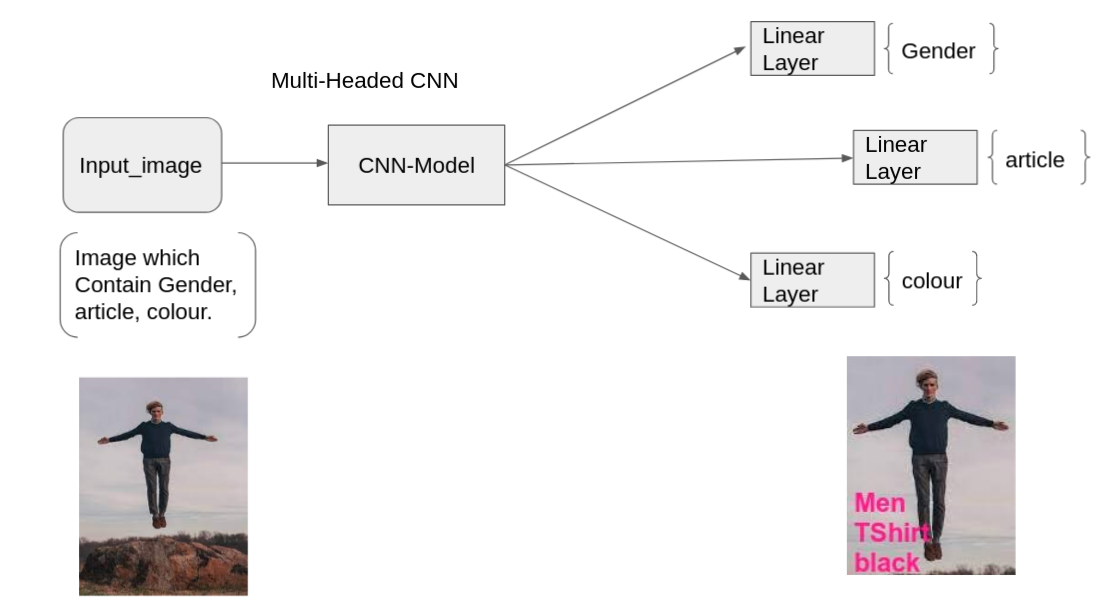

## Downloading the Dataset

We will practice on the low- resolution subset of the ‘“Fashion Product Images’” dataset available on the [kaggle website](https://www.kaggle.com/paramaggarwal/fashion-product-images-small). In addition to professional high-resolution product images, it also has multiple-label attributes describing each catalogued product,



In [ ]:
! pip install -q kaggle  #explanation about dataset*

import os
from google.colab import files

if not os.path.exists("/root/.kaggle/kaggle.json"):
  files.upload()
  ! mkdir -p ~/.kaggle
  ! mv kaggle.json ~/.kaggle/ 
  ! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              234KB  2021-07-23 06:49:54           9645  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5884  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2185  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2469  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [ ]:
! kaggle datasets download paramaggarwal/fashion-product-images-small
! mkdir -p fashion-product-images && cd fashion-product-images && unzip -qo ../fashion-product-images-small.zip && cd ..;

 96% 545M/565M [00:10<00:00, 65.4MB/s]
100% 565M/565M [00:10<00:00, 57.2MB/s]


## Dataset Preparation

- In total, we are going to use 40, 000 images. We’ll put 32, 000 of them into the training set, and the rest 8 000 will be used for  validation. To split the data, run the code given below.

- Each product is identified by an ID like 42431. You will find a map to all the products in styles.csv. fetch the image for this product from images/42431.jpg, contained in styles.csv. To make it easily for you, we have exposed some of the key product categories and their display names in styles.csv.

- Now, let’s split the single dataset file styles.csv into two different csvs:

 - train.csv 

 - val.csv

So, what can you try building? Here are some suggestions:

1. Start with an image classifier. Use the masterCategory column from styles.csv and train a convolutional neural network.

2. Extract the product descriptions from styles/42431.json.  Then run a classifier to get the masterCategory.

3. Try making your classification more sophisticated by predicting the other category labels in styles.csv.



In [ ]:
import csv
import os
import numpy as np
from PIL import Image
from tqdm import tqdm


def save_csv(data, path, fieldnames=['image_path', 'gender', 'articleType', 'baseColour']):
    with open(path, 'w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for row in data:
            writer.writerow(dict(zip(fieldnames, row)))


def split_data():
    input_folder = "fashion-product-images"
    output_folder = "fashion-product-images"
    annotation = os.path.join(input_folder, 'styles.csv')

    # open annotation file
    all_data = []
    with open(annotation) as csv_file:
        # parse it as CSV
        reader = csv.DictReader(csv_file)
        # tqdm shows pretty progress bar
        # each row in the CSV file corresponds to the image
        for row in tqdm(reader, total=reader.line_num):
            # we need image ID to build the path to the image file
            img_id = row['id']
            # we're going to use only 3 attributes
            gender = row['gender']
            articleType = row['articleType']
            baseColour = row['baseColour']
            img_name = os.path.join(input_folder, 'images', str(img_id) + '.jpg')
            # check if file is in place
            if os.path.exists(img_name):
                # check if the image has 80*60 pixels with 3 channels
                img = Image.open(img_name)
                if img.size == (60, 80) and img.mode == "RGB":
                    all_data.append([img_name, gender, articleType, baseColour])

    # set the seed of the random numbers generator, so we can reproduce the results later
    # construct a Numpy array from the list
    all_data = np.asarray(all_data)
    # Take 40000 samples in random order
    inds = np.random.choice(40000, 40000, replace=False)
    # split the data into train/val and save them as csv files
    save_csv(all_data[inds][:32000], os.path.join(output_folder, 'train.csv'))
    save_csv(all_data[inds][32000:40000], os.path.join(output_folder, 'val.csv'))

split_data()

44446it [00:06, 6530.84it/s]


## Working with the Dataset from Code

As our data annotation has more than one label, we need to tweak the way we read the data and load it in the memory. So, we’ll create a class that inherits the PyTorch Dataset. It can then parse our data annotation and extract only those  labels that interest us.  Here lies the key difference between Multi-Output and single-class classification. In the former, we return several labels against each sample taken from the dataset.

In [ ]:
# from dataset.py

import csv

import numpy as np
from PIL import Image
from torch.utils.data import Dataset

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

class AttributesDataset():
    def __init__(self, annotation_path):
        color_labels = []
        gender_labels = []
        article_labels = []

        with open(annotation_path) as f:
            reader = csv.DictReader(f)
            for row in reader:
                color_labels.append(row['baseColour'])
                gender_labels.append(row['gender'])
                article_labels.append(row['articleType'])

        self.color_labels = np.unique(color_labels)
        self.gender_labels = np.unique(gender_labels)
        self.article_labels = np.unique(article_labels)

        self.num_colors = len(self.color_labels)
        self.num_genders = len(self.gender_labels)
        self.num_articles = len(self.article_labels)

        self.color_id_to_name = dict(zip(range(len(self.color_labels)), self.color_labels))
        self.color_name_to_id = dict(zip(self.color_labels, range(len(self.color_labels))))

        self.gender_id_to_name = dict(zip(range(len(self.gender_labels)), self.gender_labels))
        self.gender_name_to_id = dict(zip(self.gender_labels, range(len(self.gender_labels))))

        self.article_id_to_name = dict(zip(range(len(self.article_labels)), self.article_labels))
        self.article_name_to_id = dict(zip(self.article_labels, range(len(self.article_labels))))


class FashionDataset(Dataset):
    def __init__(self, annotation_path, attributes, transform=None):
        super().__init__()

        self.transform = transform
        self.attr = attributes

        # initialize the arrays to store the ground truth labels and paths to the images
        self.data = []
        self.color_labels = []
        self.gender_labels = []
        self.article_labels = []

        # read the annotations from the CSV file
        with open(annotation_path) as f:
            reader = csv.DictReader(f)
            for row in reader:
                self.data.append(row['image_path'])
                self.color_labels.append(self.attr.color_name_to_id[row['baseColour']])
                self.gender_labels.append(self.attr.gender_name_to_id[row['gender']])
                self.article_labels.append(self.attr.article_name_to_id[row['articleType']])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # take the data sample by its index
        img_path = self.data[idx]

        # read image
        img = Image.open(img_path)

        # apply the image augmentations if needed
        if self.transform:
            img = self.transform(img)

        # return the image and all the associated labels
        dict_data = {
            'img': img,
            'labels': {
                'color_labels': self.color_labels[idx],
                'gender_labels': self.gender_labels[idx],
                'article_labels': self.article_labels[idx]
            }
        }
        return dict_data

## Model Description

Why Deep CNN is a Good Choice?

Neural networks can produce more than one output at one go. For example, we are predicting colour, gender as well as the article from a single image we train 3 separate models to predict each of these or just one that  does all three jobs. Obviously, we will opt for the latter. So let’s develop and train a deep CNN in PyTorch that can produce multiple outputs.

We take the EfficientNet-v2-s network. This model can do ImageNet classification, its last layer accordingly is a single classifier.
Some modifications will still be required before  this model is ready for our multi-output task,

- As we need to predict three properties, a single classifier just won’t do.  So we’ll be usinge three new classification heads called color, gender and article.

- Each head will have its own Cross-entropy loss.
Also, we need to specify different loss functions for different outputs. Color, gender and article are categorical, so while building our model, we should specify which loss function we want to use. 

- Next, we combine the loss of all output to produce a scalar value which is used to update the network. 

- As the loss values may be different for different outputs, the largest loss will then dominate the network update. It  will try to optimize the network for that particular output, while discarding others. To overcome this, we specify loss weights, which indicate how much it will contribute towards the final loss.

In this experiment, we’ve assigned 1 for color, 1 for gender and 1 for article.

Note: *These values are hyper-parameters. You should therefore try out different values, depending on the task and dataset, before assigning one.*

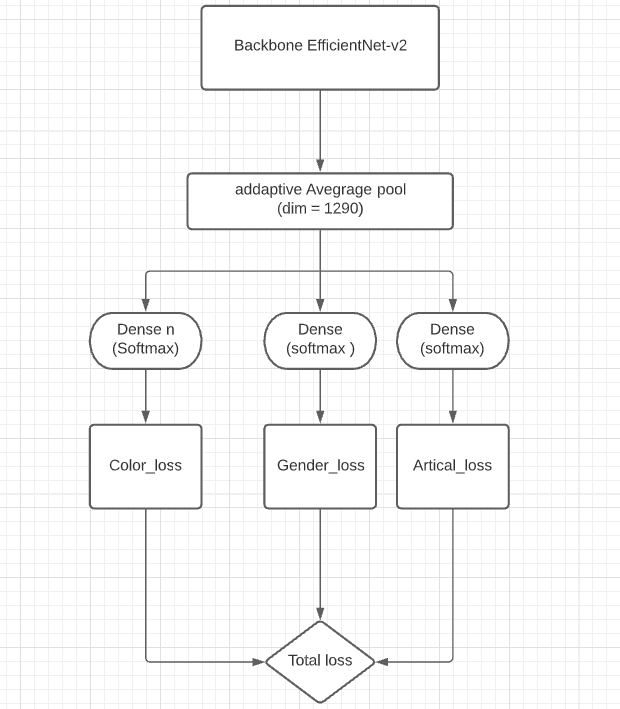

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# cfgs = [
#         # t, c, n, s, SE
#         [1,  24,  2, 1, 0],
#         [4,  48,  4, 2, 0],
#         [4,  64,  4, 2, 0],
#         [4, 128,  6, 2, 1],
#         [6, 160,  9, 1, 1],
#         [6, 256, 15, 2, 1],
#     ]

cfgs = [
        # t, c, n, s, SE
        [1,  16,  1, 1, 0],
        [2,  32,  2, 2, 0],
        [2,  64,  2, 2, 0],
        [2, 128,  3, 2, 1],
        [3, 128,  3, 1, 1],
        [3, 256,  5, 2, 1],
    ]

def _make_divisible(v, divisor, min_value=None):

    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v




 
class SELayer(nn.Module):
    def __init__(self, inp, oup, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(oup, _make_divisible(inp // reduction, 8)),
                nn.SiLU(),
                nn.Linear(_make_divisible(inp // reduction, 8), oup),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


class MBConv(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, use_se):
        super(MBConv, self).__init__()
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup
        if use_se:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                SELayer(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # fused
                nn.Conv2d(inp, hidden_dim, 3, stride, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )


    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class EffNetV2(nn.Module):
    def __init__(self, n_color_classes, n_gender_classes, n_article_classes):
        super(EffNetV2, self).__init__()
        self.cfgs = cfgs
        width_mult = 1.0

        # building first layer
        input_channel = _make_divisible(24 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = MBConv
        for t, c, n, s, use_se in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            for i in range(n):
                layers.append(block(input_channel, output_channel, s if i == 0 else 1, t, use_se))
                input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        output_channel = _make_divisible(1792 * width_mult, 8) if width_mult > 1.0 else 1792
        self.conv = conv_1x1_bn(input_channel, output_channel)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.label_op = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=output_channel, out_features=n_color_classes)
        )
        self.gender = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=output_channel, out_features=n_gender_classes)
        )
        self.article = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=output_channel, out_features=n_article_classes)
        )



    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        return {
            'color': self.label_op(x),
            'gender': self.gender(x),
            'article': self.article(x)  
        }

    
    '''
    Note: This is the forward loss function which is used in our task 
    as we can see that in our model there are three head ,one for gender 
    one for color, and one for article and we are classifying these 
    seperatly. So thats why we are using these 3 cross entropy loss 
    respectively and finally we are adding all thses respective 
    cross_entropys or we can also take weighted addition for all three
    cross_entropys. In this experiment we have weight as unity for all
    the Cross_entropys.
    '''
    def get_loss(self, net_output, ground_truth):
        color_loss = F.cross_entropy(net_output['color'], ground_truth['color_labels'])     
        gender_loss = F.cross_entropy(net_output['gender'], ground_truth['gender_labels'])
        article_loss = F.cross_entropy(net_output['article'], ground_truth['article_labels'])
        loss = 2*color_loss + gender_loss + 3*article_loss
        return loss, {'color': color_loss, 'gender': gender_loss, 'article': article_loss}





## Training

Let's define helper function to calculate the metrics of our model during training / testing.

In [ ]:
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def calculate_metrics(output, target):
    _, predicted_color = output['color'].cpu().max(1)
    gt_color = target['color_labels'].cpu()

    _, predicted_gender = output['gender'].cpu().max(1)
    gt_gender = target['gender_labels'].cpu()

    _, predicted_article = output['article'].cpu().max(1)
    gt_article = target['article_labels'].cpu()

    with warnings.catch_warnings():  # sklearn may produce a warning when processing zero row in confusion matrix
        warnings.simplefilter("ignore")
        accuracy_color = accuracy_score(y_true=gt_color.numpy(), y_pred=predicted_color.numpy())
        accuracy_gender = accuracy_score(y_true=gt_gender.numpy(), y_pred=predicted_gender.numpy())
        accuracy_article = accuracy_score(y_true=gt_article.numpy(), y_pred=predicted_article.numpy())

    return accuracy_color, accuracy_gender, accuracy_article

Defining a helper function at this point shows an image grid with labels, which helps us understand our data better

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize_gt_data(dataset, attributes):
    imgs = []
    gt_labels = []

    n_cols = 5
    n_rows = 3

    # store the original transforms from the dataset
    transforms = dataset.transform
    # and not use them during visualization
    dataset.transform = None

    for img_idx in range(n_cols * n_rows):
        sample = dataset[img_idx]
        img = sample['img']
        labels = sample['labels']
        gt_color = attributes.color_id_to_name[labels['color_labels']]
        gt_gender = attributes.gender_id_to_name[labels['gender_labels']]
        gt_article = attributes.article_id_to_name[labels['article_labels']]
        
        imgs.append(img)
        gt_labels.append("{}\n{}\n{}".format(gt_gender, gt_article, gt_color))

    title = "Ground truth labels"

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,10))
    axs = axs.flatten()
    for img, ax, label in zip(imgs, axs, gt_labels):
        ax.set_xlabel(label, rotation=0)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.imshow(img)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    # restore original transforms
    dataset.transform = transforms

To estimate the accuracy of the model during training we will need the validation procedure

In [ ]:
def checkpoint_load(model, name):
    print('Restoring checkpoint: {}'.format(name))
    model.load_state_dict(torch.load(name, map_location='cpu'))
    epoch = int(os.path.splitext(os.path.basename(name))[0].split('-')[1])
    return epoch


def net_output_to_predictions(output):
    _, predicted_colors = output['color'].cpu().max(1)
    _, predicted_genders = output['gender'].cpu().max(1)
    _, predicted_articles = output['article'].cpu().max(1)

    return predicted_colors.numpy().tolist(), predicted_genders.numpy().tolist(), predicted_articles.numpy().tolist()


def validate(model, dataloader, device, logger=None, epoch=None, checkpoint=None):
    if checkpoint is not None:
        checkpoint_load(model, checkpoint)

    model.eval()
    color_predictions = []
    gender_predictions = []
    article_predictions = []
    with torch.no_grad():
        avg_loss = 0
        accuracy_color = 0
        accuracy_gender = 0
        accuracy_article = 0

        for batch in dataloader:
            img = batch['img']
            target_labels = batch['labels']
            target_labels = {t: target_labels[t].to(device) for t in target_labels}
            output = model(img.to(device))

            val_train, val_train_losses = model.get_loss(output, target_labels)
            avg_loss += val_train.item()
            batch_accuracy_color, batch_accuracy_gender, batch_accuracy_article = \
                calculate_metrics(output, target_labels)

            accuracy_color += batch_accuracy_color
            accuracy_gender += batch_accuracy_gender
            accuracy_article += batch_accuracy_article

            (batch_color_predictions,
             batch_gender_predictions,
             batch_article_predictions) = net_output_to_predictions(output)

            color_predictions.extend(batch_color_predictions)
            gender_predictions.extend(batch_gender_predictions)
            article_predictions.extend(batch_article_predictions)

    n_samples = len(dataloader)
    avg_loss /= n_samples
    accuracy_color /= n_samples
    accuracy_gender /= n_samples
    accuracy_article /= n_samples
    print('-' * 72)
    print("Validation  loss: {:.4f}, color: {:.4f}, gender: {:.4f}, article: {:.4f}\n".format(
        avg_loss, accuracy_color, accuracy_gender, accuracy_article))

    if logger is not None and epoch is not None:
        logger.add_scalar("val_loss", avg_loss, epoch)
        logger.add_scalar("val_accuracy/color", accuracy_color, epoch)
        logger.add_scalar("val_accuracy/gender", accuracy_gender, epoch)
        logger.add_scalar("val_accuracy/article", accuracy_article, epoch)
    model.train()

    return color_predictions, gender_predictions, article_predictions

Now, we're ready to define the training procedure:

In [ ]:
import os
from datetime import datetime
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


def get_cur_time():
    return datetime.strftime(datetime.now(), '%Y-%m-%d_%H-%M')


def checkpoint_save(model, name, epoch):
    f = os.path.join(name, 'checkpoint-{:06d}.pth'.format(epoch))
    torch.save(model.state_dict(), f)
    print('Saved checkpoint:', f)

    return f
    


def train(start_epoch=1, N_epochs=50, batch_size=16, num_workers=2):
    attributes_file = 'fashion-product-images/styles.csv'
    device = torch.device('cuda')

    # attributes variable contains labels for the categories in the dataset and mapping between string names and IDs
    attributes = AttributesDataset(attributes_file)

    # specify image transforms for augmentation during training
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0),
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2),
                                shear=None, fill=(255, 255, 255)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # during validation we use only tensor and normalization transforms
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_dataset = FashionDataset('fashion-product-images/train.csv', attributes, train_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = FashionDataset('fashion-product-images/val.csv', attributes, val_transform)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    model = EffNetV2(n_color_classes=attributes.num_colors,
                             n_gender_classes=attributes.num_genders,
                             n_article_classes=attributes.num_articles).to(device)

    optimizer = torch.optim.Adam(model.parameters())

    logdir = os.path.join('logs', get_cur_time())
    print(logdir)
    savedir = os.path.join('checkpoints', get_cur_time())
    print(savedir)
    os.makedirs(logdir, exist_ok=False)
    os.makedirs(savedir, exist_ok=False)
    logger = SummaryWriter(logdir)

    n_train_samples = len(train_dataloader)

    
    visualize_gt_data(val_dataset, attributes)
    print("\nAll gender labels:\n", attributes.gender_labels)
    print("\nAll color labels:\n", attributes.color_labels)
    print("\nAll article labels:\n", attributes.article_labels)

    print("Starting training ...")

    checkpoint_path = None
    for epoch in range(start_epoch, N_epochs + 1):
        total_loss = 0
        accuracy_color = 0
        accuracy_gender = 0
        accuracy_article = 0

        for batch in train_dataloader:
            optimizer.zero_grad()

            img = batch['img']
            target_labels = batch['labels']
            target_labels = {t: target_labels[t].to(device) for t in target_labels}
            output = model(img.to(device))

            loss_train, losses_train = model.get_loss(output, target_labels)
            total_loss += loss_train.item()
            batch_accuracy_color, batch_accuracy_gender, batch_accuracy_article = \
                calculate_metrics(output, target_labels)

            accuracy_color += batch_accuracy_color
            accuracy_gender += batch_accuracy_gender
            accuracy_article += batch_accuracy_article

            loss_train.backward()
            optimizer.step()

        print("epoch {:4d}, loss: {:.4f}, color: {:.4f}, gender: {:.4f}, article: {:.4f}".format(
            epoch,
            total_loss / n_train_samples,
            accuracy_color / n_train_samples,
            accuracy_gender / n_train_samples,
            accuracy_article / n_train_samples))

        logger.add_scalar('train_loss', total_loss / n_train_samples, epoch)

        if epoch % 25 == 0:
            checkpoint_path = checkpoint_save(model, savedir, epoch)

        if epoch % 5 == 0:
            validate(model, val_dataloader, device, logger, epoch)
            
    checkpoint_path = checkpoint_save(model, savedir, epoch - 1)

    return checkpoint_path

logs/2021-07-23_10-20
checkpoints/2021-07-23_10-20


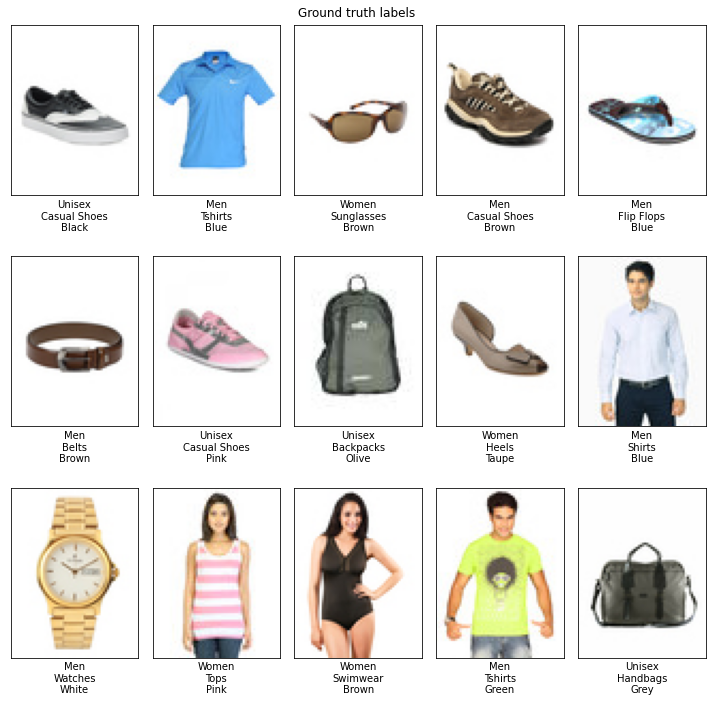


All gender labels:
 ['Boys' 'Girls' 'Men' 'Unisex' 'Women']

All color labels:
 ['Beige' 'Black' 'Blue' 'Bronze' 'Brown' 'Burgundy' 'Charcoal'
 'Coffee Brown' 'Copper' 'Cream' 'Fluorescent Green' 'Gold' 'Green' 'Grey'
 'Grey Melange' 'Khaki' 'Lavender' 'Lime Green' 'Magenta' 'Maroon' 'Mauve'
 'Metallic' 'Multi' 'Mushroom Brown' 'Mustard' 'NA' 'Navy Blue' 'Nude'
 'Off White' 'Olive' 'Orange' 'Peach' 'Pink' 'Purple' 'Red' 'Rose' 'Rust'
 'Sea Green' 'Silver' 'Skin' 'Steel' 'Tan' 'Taupe' 'Teal' 'Turquoise Blue'
 'White' 'Yellow']

All article labels:
 ['Accessory Gift Set' 'Baby Dolls' 'Backpacks' 'Bangle' 'Basketballs'
 'Bath Robe' 'Beauty Accessory' 'Belts' 'Blazers' 'Body Lotion'
 'Body Wash and Scrub' 'Booties' 'Boxers' 'Bra' 'Bracelet' 'Briefs'
 'Camisoles' 'Capris' 'Caps' 'Casual Shoes' 'Churidar' 'Clothing Set'
 'Clutches' 'Compact' 'Concealer' 'Cufflinks' 'Cushion Covers' 'Deodorant'
 'Dresses' 'Duffel Bag' 'Dupatta' 'Earrings' 'Eye Cream' 'Eyeshadow'
 'Face Moisturisers' 'Face Sc

In [ ]:
last_checkpoint_path = train()

**Find all the training logs [here](https://tensorboard.dev/experiment/xcQtXJxlSLSVFdpOAB9iqA/)**

## Evaluation

Now that  we have trained the models, let's evaluate them with our validation set. Also, at this point visualizing some additional information, like confusion matrix can help us understand our models better.

In [ ]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


def visualize_grid(dataset, attributes, color_predictions, gender_predictions, article_predictions):
    imgs = []
    labels = []
    predicted_color_all = []
    predicted_gender_all = []
    predicted_article_all = []

    gt_labels = []
    gt_color_all = []
    gt_gender_all = []
    gt_article_all = []

    
    # store the original transforms from the dataset
    transforms = dataset.transform
    # and not use them during visualization
    dataset.transform = None

    for (sample, 
         predicted_color, 
         predicted_gender, 
         predicted_article) in zip(
             dataset, color_predictions, gender_predictions, article_predictions):
        predicted_color = attributes.color_id_to_name[predicted_color]
        predicted_gender = attributes.gender_id_to_name[predicted_gender]
        predicted_article = attributes.article_id_to_name[predicted_article]

        gt_color = attributes.color_id_to_name[sample['labels']['color_labels']]
        gt_gender = attributes.gender_id_to_name[sample['labels']['gender_labels']]
        gt_article = attributes.article_id_to_name[sample['labels']['article_labels']]

        predicted_color_all.append(predicted_color)
        predicted_gender_all.append(predicted_gender)
        predicted_article_all.append(predicted_article)

        gt_color_all.append(gt_color)
        gt_gender_all.append(gt_gender)
        gt_article_all.append(gt_article)

        imgs.append(sample['img'])
        labels.append("{}\n{}\n{}".format(predicted_gender, predicted_article, predicted_color))
        gt_labels.append("{}\n{}\n{}".format(gt_gender, gt_article, gt_color))

    # restore original transforms
    dataset.transform = transforms

    # Draw confusion matrices
    # color
    cn_matrix = confusion_matrix(
        y_true=gt_color_all,
        y_pred=predicted_color_all,
        labels=attributes.color_labels,
        normalize='true')
    
    plt.rcParams.update({'font.size': 5})
    plt.rcParams.update({'figure.dpi': 300})
    ConfusionMatrixDisplay(cn_matrix, attributes.color_labels).plot(
        include_values=False, xticks_rotation='vertical')
    plt.title("Colors")
    plt.tight_layout()
    plt.show()

    # gender
    cn_matrix = confusion_matrix(
        y_true=gt_gender_all,
        y_pred=predicted_gender_all,
        labels=attributes.gender_labels,
        normalize='true')
    ConfusionMatrixDisplay(cn_matrix, attributes.gender_labels).plot(
        xticks_rotation='horizontal')
    plt.title("Genders")
    plt.tight_layout()
    plt.show()

    plt.rcParams.update({'font.size': 2.5})
    cn_matrix = confusion_matrix(
        y_true=gt_article_all,
        y_pred=predicted_article_all,
        labels=attributes.article_labels,
        normalize='true')
    ConfusionMatrixDisplay(cn_matrix, attributes.article_labels).plot(
        include_values=False, xticks_rotation='vertical')
    plt.title("Article types")
    plt.show()

    plt.rcParams.update({'font.size': 5})
    plt.rcParams.update({'figure.dpi': 100})
    title = "Predicted labels"
    n_cols = 5
    n_rows = 1
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,10))
    axs = axs.flatten()
    for img, ax, label in zip(imgs, axs, labels):
        ax.set_xlabel(label, rotation=0)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.imshow(img)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



def test(checkpoint_path):
    attributes_file = 'fashion-product-images/styles.csv'

    device = torch.device("cuda")
    # attributes variable contains labels for the categories in the dataset and mapping between string names and IDs
    attributes = AttributesDataset(attributes_file)

    # during validation we use only tensor and normalization transforms
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    test_dataset = FashionDataset('fashion-product-images/val.csv', attributes, val_transform)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=8)

    model = EffNetV2(n_color_classes=attributes.num_colors, n_gender_classes=attributes.num_genders,
                             n_article_classes=attributes.num_articles).to(device)

    model_predictions = validate(model, test_dataloader, device, checkpoint=checkpoint_path)

    # Visualization of the trained model
    visualize_grid(test_dataset, attributes, *model_predictions)

Restoring checkpoint: checkpoints/2021-07-23_10-20/checkpoint-000049.pth


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


------------------------------------------------------------------------
Validation  loss: 4.5510, color: 0.6342, gender: 0.8894, article: 0.8264



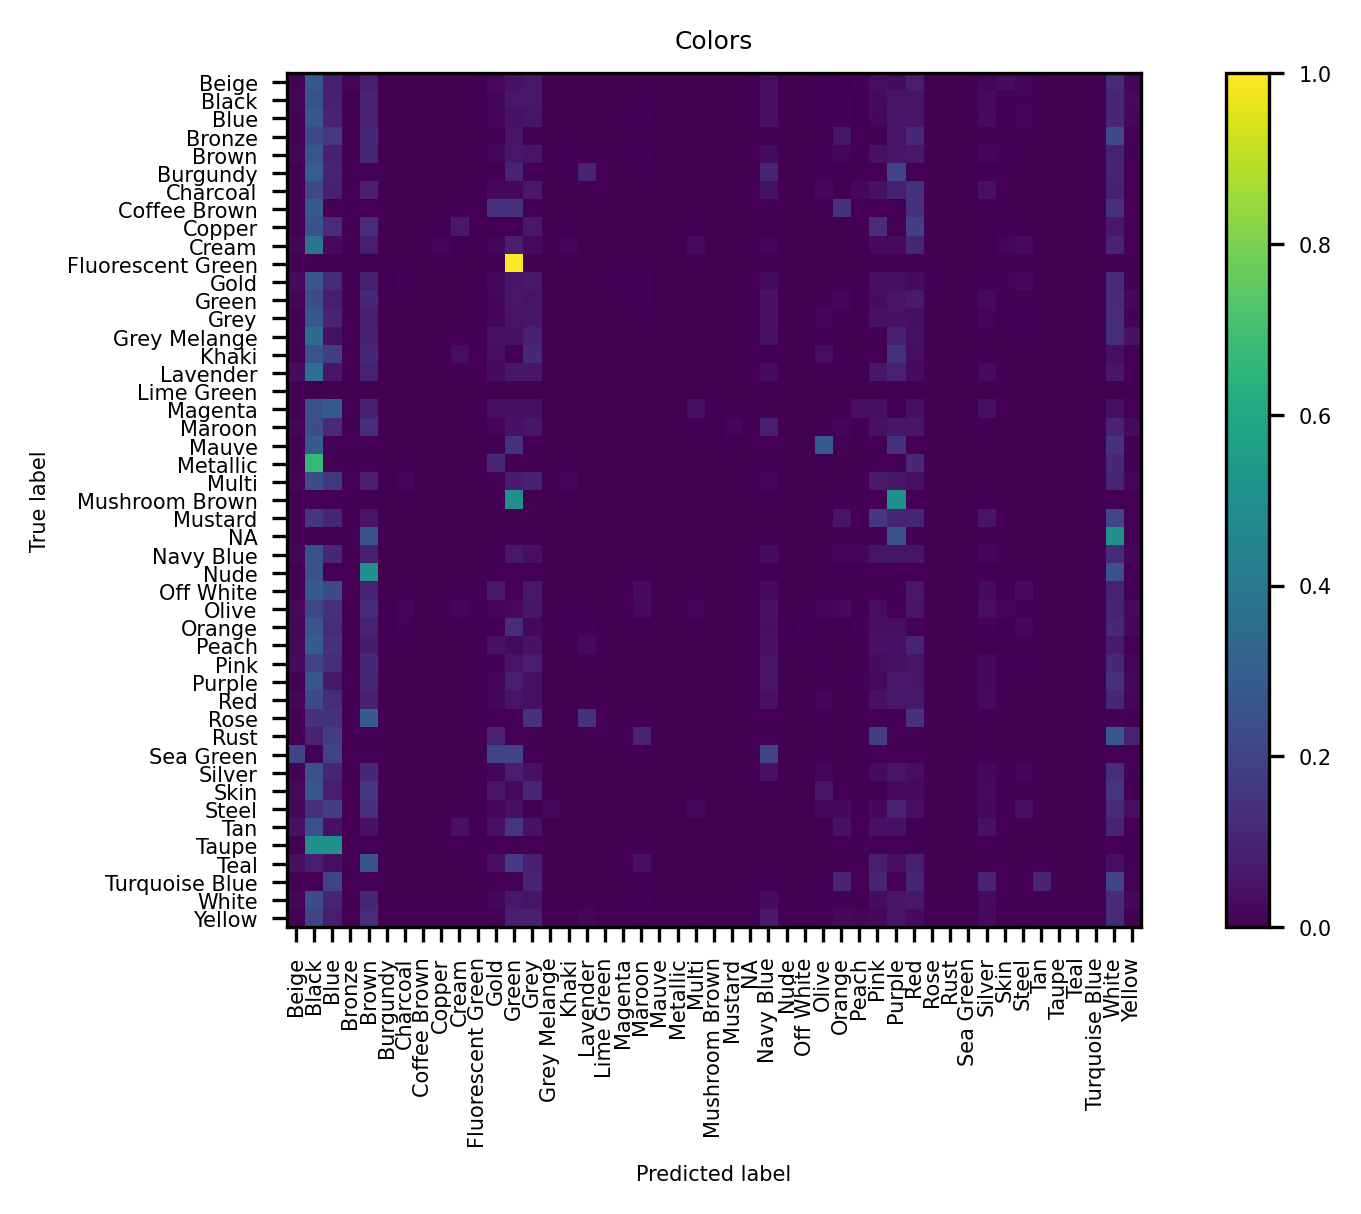

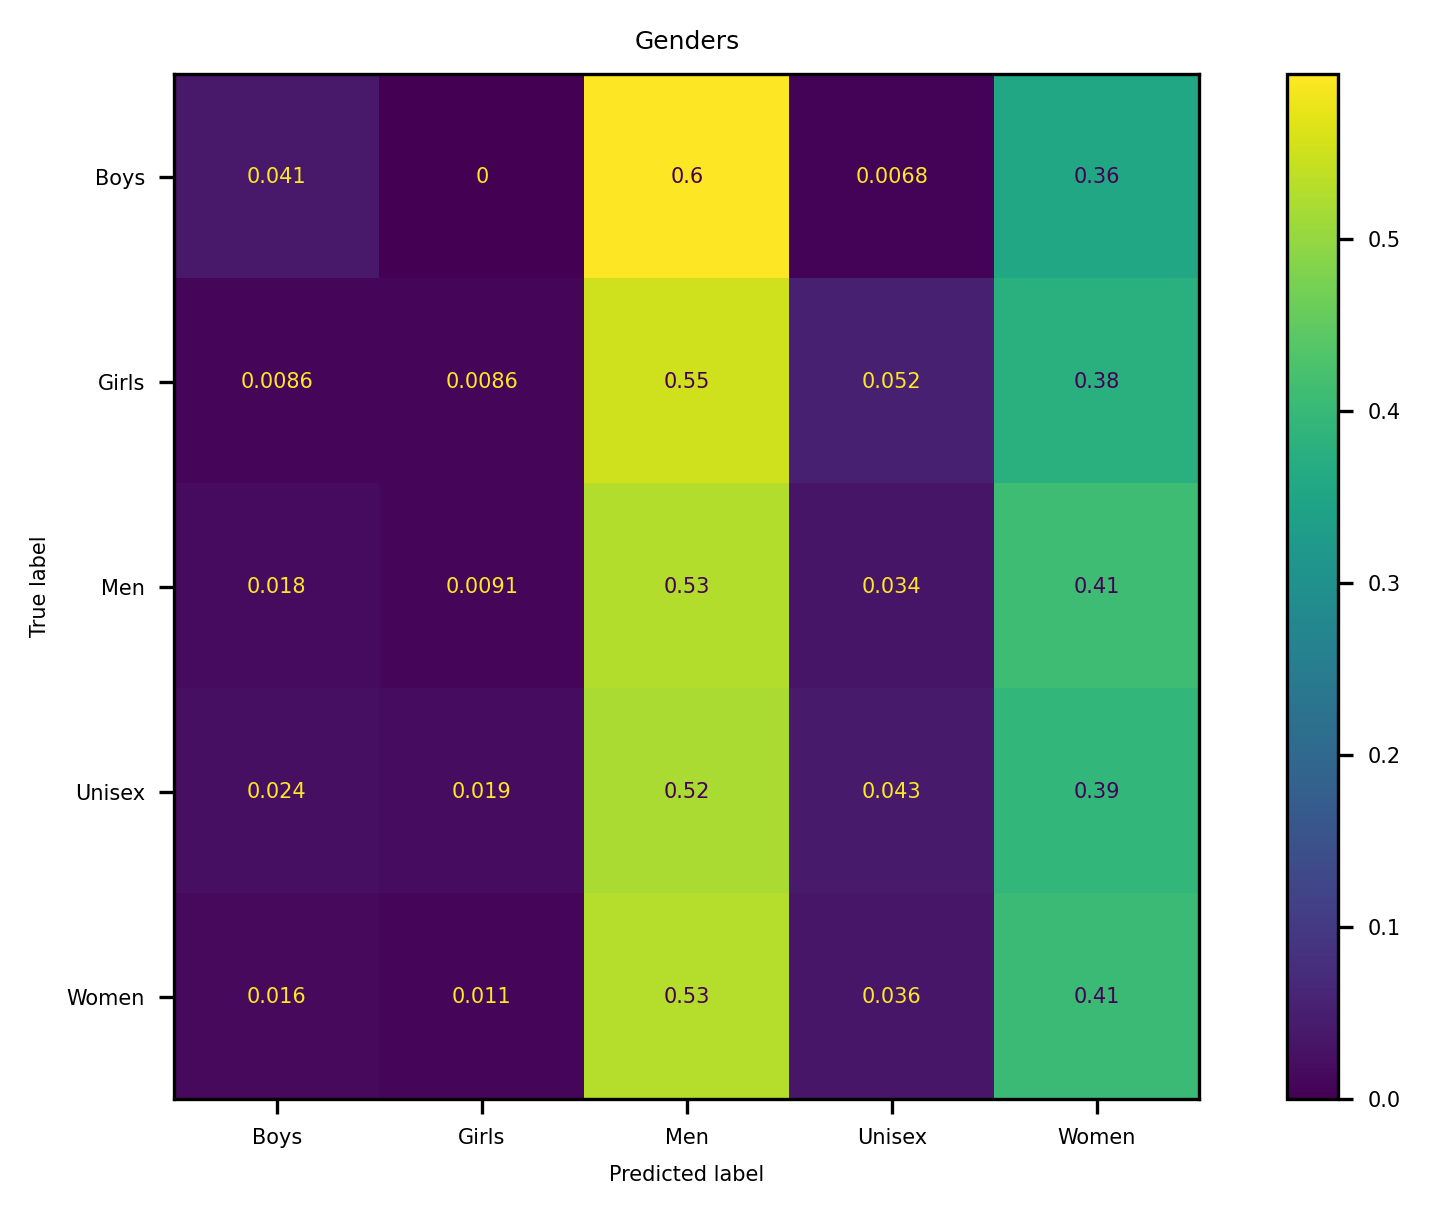

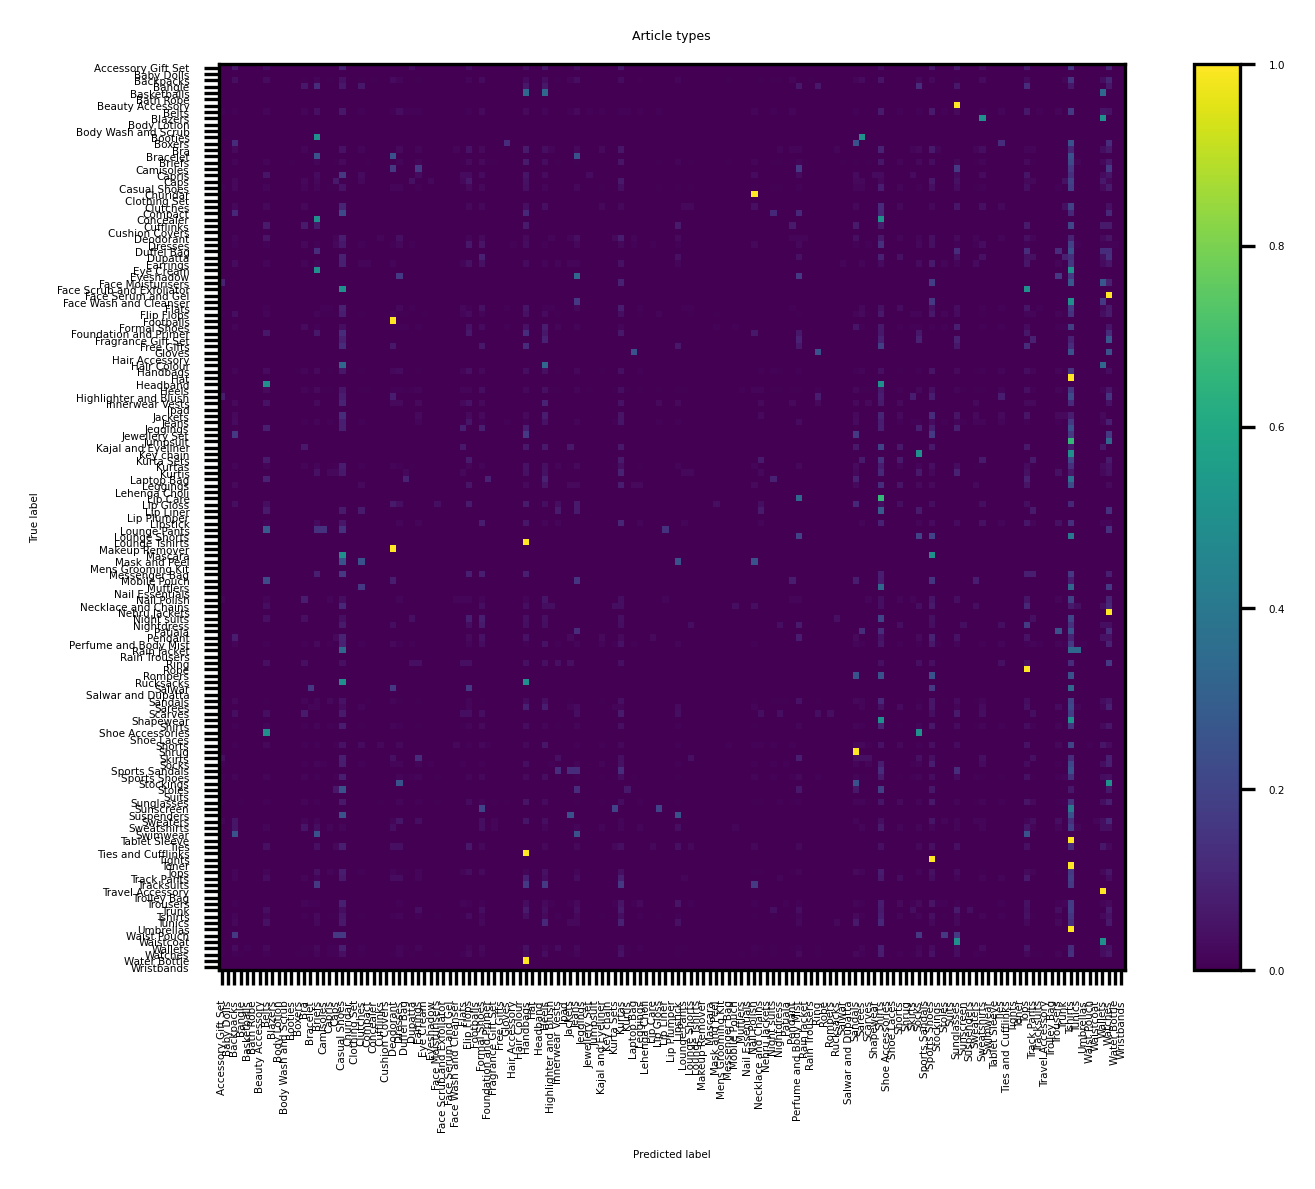

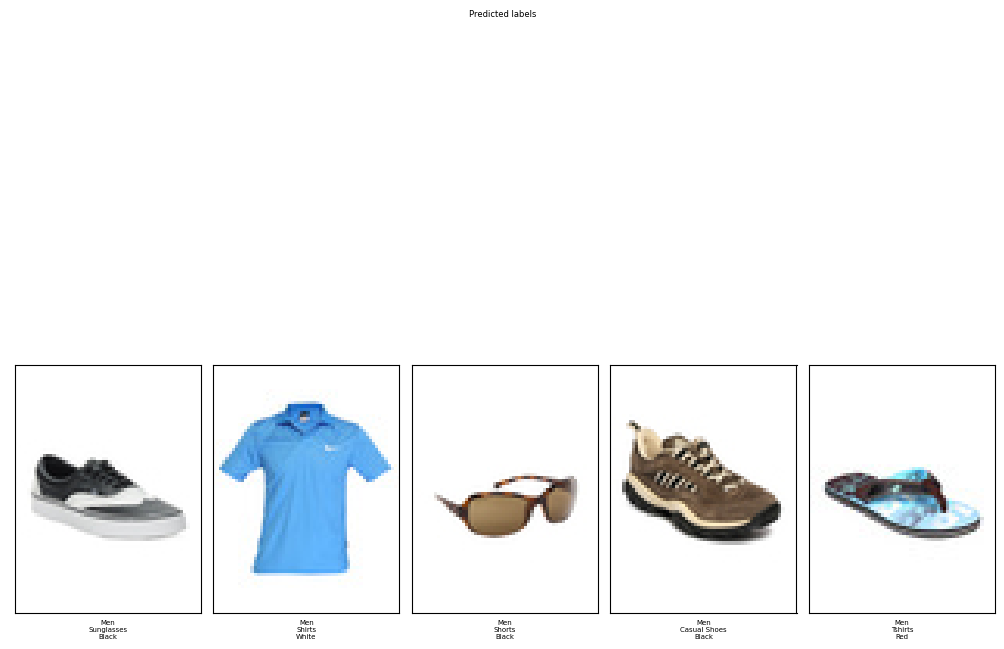

In [ ]:
% matplotlib inline
test(last_checkpoint_path)